# The Vatican, a hidden ally in the fight to climate change

## Making of the map

In this notebook I create a map showing the number of Catholics per country as a percentage of the country's population. Data comes from the Pew Forum's 2011 Demographic Study  __["Global Christianity – A Report on the Size and Distribution of the World’s Christian Population"](https://www.pewforum.org/2011/12/19/global-christianity-exec/)__. 

### Data preparation

Importing the necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

Scraping data from __[Table: Christian Population as Percentages of Total Population by Country]('https://www.pewforum.org/2011/12/19/table-christian-population-as-percentages-of-total-population-by-country/' )__

In [2]:
df = pd.read_html('https://www.pewforum.org/2011/12/19/table-christian-population-as-percentages-of-total-population-by-country/' )[0]
# check the data
df.head()

,Country,Percentage of 2010 Population that is Catholic,Percentage of 2010 Population that is Protestant,Percentage of 2010 Population that is Orthodox,Percentage of 2010 Population that is Other Christian,Percentage of 2010 Population that is Christian
0,Afghanistan,< 0.1%,< 0.1%,< 0.1%,< 0.1%,< 0.1%
1,Albania,10.2%,0.3%,7.5%,< 0.1%,18.0%
2,Algeria,< 0.1%,< 0.1%,< 0.1%,< 0.1%,< 0.1%
3,American Samoa,19.7%,59.5%,< 0.1%,19.2%,98.3%
4,Andorra,88.2%,0.3%,0.3%,0.7%,89.5%


I need to clean the data and keep the column I am interested in only:

In [3]:
df = df.drop(['Percentage of 2010 Population that is Protestant', 'Percentage of 2010 Population that is Orthodox',
        'Percentage of 2010 Population that is Other Christian', 'Percentage of 2010 Population that is Christian'], 
             axis =1)
df.head()

,Country,Percentage of 2010 Population that is Catholic
0,Afghanistan,< 0.1%
1,Albania,10.2%
2,Algeria,< 0.1%
3,American Samoa,19.7%
4,Andorra,88.2%


Values written like "< 0.1%" might be troublesome to interpret and not recognized. Better to change them directly to zero as on the map the won't be much visible anyway:

In [4]:
df = df.replace('< 0.1%', '0%')

df.head()

,Country,Percentage of 2010 Population that is Catholic
0,Afghanistan,0%
1,Albania,10.2%
2,Algeria,0%
3,American Samoa,19.7%
4,Andorra,88.2%


Let's check for null values:

In [5]:
# checking for null values: 232 out of 232 entries are non-null

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 2 columns):
 #   Column                                          Non-Null Count  Dtype 
---  ------                                          --------------  ----- 
 0   Country                                         232 non-null    object
 1   Percentage of 2010 Population that is Catholic  232 non-null    object
dtypes: object(2)
memory usage: 3.8+ KB


It seems like we have 232 non-null entries out of 232 entries, hence no missing values so far.

In [6]:
df.head()

,Country,Percentage of 2010 Population that is Catholic
0,Afghanistan,0%
1,Albania,10.2%
2,Algeria,0%
3,American Samoa,19.7%
4,Andorra,88.2%


I now want to eliminate the percentage sign and define the variable "Percentage of 2010 Population that is Catholic" as a float:

In [7]:
# eliminate % sign

df['Percentage of 2010 Population that is Catholic'] = df['Percentage of 2010 Population that is Catholic'].str[:-1]

In [8]:
# convert into float

df['Percentage of 2010 Population that is Catholic']= df['Percentage of 2010 Population that is Catholic'].astype(dtype='float', errors= 'ignore')

In [9]:
df.head()

,Country,Percentage of 2010 Population that is Catholic
0,Afghanistan,0
1,Albania,10.2
2,Algeria,0
3,American Samoa,19.7
4,Andorra,88.2


### Getting the geocoordinates

I will use a shapefile already available from the geopandas library:

In [10]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


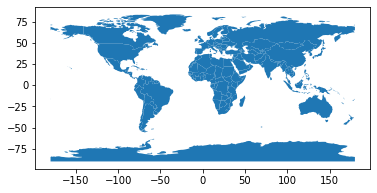

In [11]:
# let's try to plot it

world.plot()

I want to check how many countries the data set covers

In [12]:
world.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   pop_est     177 non-null    int64   
 1   continent   177 non-null    object  
 2   name        177 non-null    object  
 3   iso_a3      177 non-null    object  
 4   gdp_md_est  177 non-null    float64 
 5   geometry    177 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 8.4+ KB


Apparently we will have more data from the first data set than from the one with the geocoordinates.

As I will join them based on the country name, it is important to check that the names match. Unfortunately this is a manual procedure and will require to download both data sets as Excel files.

In [13]:
# df.to_excel('df.xlsx')
# world.to_excel('world.xlsx')

I found a few wrong names, below the code to adjust them:

In [14]:
# modifying wrong country names in df data set

df = df.replace({'Country' : 'Bosnia-Herzegovina'},'Bosnia and Herz.')

df = df.replace({'Country' : 'Central African Republic'},'Central African Rep.')

df = df.replace({'Country' : 'Ivory Coast'},"Côte d'Ivoire")

df = df.replace({'Country' : 'Democratic Republic of the Congo'},"Dem. Rep. Congo")

df = df.replace({'Country' : 'Republic of the Congo'},"Congo")

df = df.replace({'Country' : 'Czech Republic'},"Czechia")

df = df.replace({'Country' : 'Dominican Republic'},"Dominican Rep.")

df = df.replace({'Country' : 'Western Sahara'},"W. Sahara")

df = df.replace({'Country' : 'Falkland Islands (Malvinas)'},"Falkland Is.")

df = df.replace({'Country' : 'Guinea Bissau'},"Guinea-Bissau")

df = df.replace({'Country' : 'Equatorial Guinea'},"Eq. Guinea")

df = df.replace({'Country' : 'Republic of Macedonia'},"Macedonia")

df = df.replace({'Country' : 'Burma (Myanmar)'},"Myanmar")

df = df.replace({'Country' : 'Palestinian territories'},"Palestine")

df = df.replace({'Country' : 'Solomon Islands'},"Solomon Is.")

df = df.replace({'Country' : 'South Sudan'},"S. Sudan")

df = df.replace({'Country' : 'United States'},"United States of America")

Now, I can perform a left join on the world data set:

In [15]:
#merge the datasets

df_new= world.set_index('name').join(df.set_index('Country'))

df_new.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 177 entries, Fiji to S. Sudan
Data columns (total 6 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   pop_est                                         177 non-null    int64   
 1   continent                                       177 non-null    object  
 2   iso_a3                                          177 non-null    object  
 3   gdp_md_est                                      177 non-null    float64 
 4   geometry                                        177 non-null    geometry
 5   Percentage of 2010 Population that is Catholic  172 non-null    object  
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 14.7+ KB


In the new dataframe, the variable "Percentage of 2010 Population that is Catholic" is an object again. Let's turn it into float:

In [16]:
df_new['Percentage of 2010 Population that is Catholic']= df_new['Percentage of 2010 Population that is Catholic'].astype('float')

### Plotting

The dataframe is fine so we can attempt a first plot:

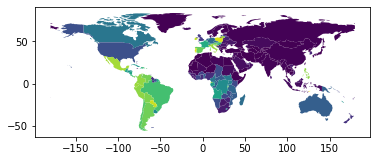

In [17]:
df_new.plot('Percentage of 2010 Population that is Catholic')

As everything turned out well, let's make the plot prettier:

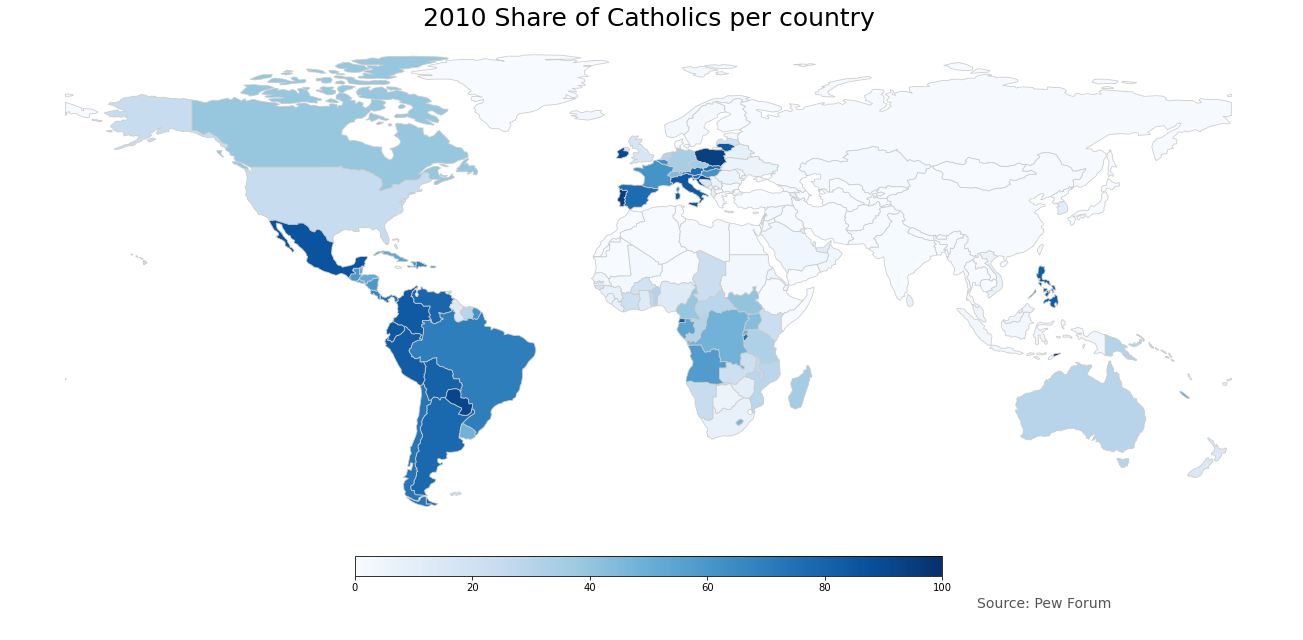

In [25]:
# store the variable to be visualized
variable = 'Percentage of 2010 Population that is Catholic'

# range for the choropleth values
vmin, vmax = 0, 100

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))

# remove the axis
ax.axis('off')

# add a title and annotation
ax.set_title('2010 Share of Catholics per country', fontdict={'fontsize': '25', 'fontweight' : '2'})
ax.annotate('Source: Pew Forum', xy=(0.75, .05), xycoords='figure fraction', fontsize=14, color='#555555')

# create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty the array for the data range
sm.set_array([]) 

# add the colorbar to the figure
fig.colorbar(sm, orientation="horizontal", fraction=0.036, pad=0.05, aspect = 30)

# plot the map
df_new.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

Finally, I will save the map in a png file:

In [26]:
fig.savefig('catholicsmap.png', dpi=300)